# Lab 4
Welcome to the fourth lab. In this lab, we will work with another regularization.

## Imports

In [1]:
from typing import Optional, List, Tuple

import matplotlib.pyplot as plt
import torch
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
from torch import Tensor

set_matplotlib_formats('png', 'pdf')


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# OLS → Ridge → Lasso

You'll work through three linear models on a small **deterministic** dataset:

1. **OLS** (normal equations)  
2. **Ridge** (closed-form; L2 penalty)  
3. **Lasso** (coordinate descent; L1 penalty)

We'll end with a side-by-side comparison.


## Step 0 — Load the dataset

In [3]:
def get_data():
    """
    Deterministic dataset (n=8, p=4).
    y is generated from: y = -0.5 + 2*x0 - 1.5*x2 + noise (small, fixed).
    """
    X = np.array([
        [1,0,2,0],
        [0,1,0,1],
        [2,1,0,0],
        [0,0,1,2],
        [1,2,0,1],
        [2,0,1,0],
        [1,1,1,1],
        [0,2,2,0],
    ], dtype=float)
    y = np.array([-0.5 + 2.0*(x0) + -1.5*(x2) + e for (x0, x1, x2, x3), e in zip(
        X,
        [0.10, -0.20, 0.05, 0.00, -0.05, 0.20, -0.10, 0.15]
    )], dtype=float)
    return X, y

X, y = get_data()
print("X shape:", X.shape, " y shape:", y.shape)
print("First 3 rows of X:\n", X[:3])
print("First 3 y:", y[:3])


X shape: (8, 4)  y shape: (8,)
First 3 rows of X:
 [[1. 0. 2. 0.]
 [0. 1. 0. 1.]
 [2. 1. 0. 0.]]
First 3 y: [-1.4  -0.7   3.55]



## Task 1 — OLS (Normal Equations)
Implement OLS via $\tilde X^\top \tilde X \theta = \tilde X^\top y$ using `np.linalg.solve`.


In [4]:
def fit_ols_normal_eq(X, y):
    return np.linalg.solve(X.T @ X, X.T @ y)



## Task 1b — OLS (Gradient Descent) with Epoch Logging
Implement GD updates and record '($\beta$, intercept)` at each epoch.


In [5]:
def fit_ols_gd_with_history(X, y, epochs=120, lr=0.05):
    # Add intercept term explicitly
    X_intercept = np.c_[np.ones(X.shape[0]), X]  # Prepend 1s column
    n_samples, n_features = X_intercept.shape
    beta = np.zeros(n_features)
    history = []
    
    for epoch in range(epochs):
        y_pred = X_intercept @ beta
        gradient = -2 * X_intercept.T @ (y - y_pred) / n_samples
        beta -= lr * gradient
        history.append((beta.copy(), beta[0]))  # (coefficients, intercept)
    
    return history



## What is Ridge?

**Ridge regression** adds an \(L_2\) penalty to the OLS loss:

$
\min_{\beta,\,b}\; \frac{1}{2n}\sum_{i=1}^n (y_i - b - x_i^\top \beta)^2 \;+\; \frac{\lambda}{2}\|\beta\|_2^2
$

- Closed-form (intercept unpenalized): $ \theta = (\tilde X^\top \tilde X + \lambda D)^{-1}\tilde X^\top y , D=\mathrm{diag}(0,1,\ldots,1)$.



## Task 2 — Ridge (Closed-Form, intercept unpenalized)
Implement closed-form Ridge with $D=diag(0,1,...,1)$.


In [6]:
def fit_ridge_closed_form(X, y, lam=0.5):
    X = np.c_[np.ones(X.shape[0]), X] 
    n_samples, n_features = X.shape
    D = np.eye(n_features)
    D[0, 0] = 0
    beta = np.linalg.solve(X.T @ X + lam * D, X.T @ y)
    return beta


In [7]:
#Testing the insertion of the intercept column and unpenalized eye matrix for the intercept
X_test = np.c_[np.ones(X.shape[0]), X] 
n_samples, n_features = X_test.shape
D = np.eye(n_features)
D[0, 0] = 0 
print(D)
print(X_test)

[[0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[1. 1. 0. 2. 0.]
 [1. 0. 1. 0. 1.]
 [1. 2. 1. 0. 0.]
 [1. 0. 0. 1. 2.]
 [1. 1. 2. 0. 1.]
 [1. 2. 0. 1. 0.]
 [1. 1. 1. 1. 1.]
 [1. 0. 2. 2. 0.]]



## Task 2b — Ridge (Gradient Descent) with Epoch Logging
Implement GD with gradient $\frac{1}{n} \tilde X^\top \tilde X \theta - y + \lambda * D \theta$.


In [8]:
def fit_ridge_gd_with_history(X, y, lam=0.5, epochs=120, lr=0.05):
    X_intercept = np.c_[np.ones(X.shape[0]), X] 
    n_samples, n_features = X_intercept.shape
    beta = np.zeros(n_features)
    history = []
    
    D = np.ones(n_features)
    D[0] = 0.0 
    
    for epoch in range(epochs):
        y_pred = X_intercept @ beta
        gradient = (X_intercept.T @ (y_pred - y)) / n_samples + lam * (D * beta)
        beta -= lr * gradient
        history.append((beta.copy(), beta[0]))
    
    return history



## What is Lasso?

**Lasso** (Least Absolute Shrinkage and Selection Operator) solves

$
\min_{\beta,\,b}\; \frac{1}{2n}\sum_{i=1}^n (y_i - b - x_i^\top \beta)^2 \;+\; \alpha \|\beta\|_1
$

- The $L_1$ penalty encourages **sparse** coefficients — some become exactly zero.



## Task 3 — Lasso (Coordinate Descent) with Epoch Logging
Standardize features; after each full sweep, append rescaled `(beta, intercept)` to history.


In [ ]:
def soft_threshold(z, g):
    return np.sign(z) * np.maximum(np.abs(z) - g, 0)

def fit_lasso_cd_with_history(X, y, alpha=0.2, epochs=40):
    n_samples, n_features = X.shape
    beta = np.zeros(n_features)
    intercept = 0.0 
    history = []
    
    col_norms = np.sum(X**2, axis=0) / n_samples

    for epoch in range(epochs):
        residual = y - intercept - X @ beta
        intercept = residual.mean()

        for i in range(n_features):
            residual_i = residual + X[:, i] * beta[i]
            z = X[:, i] @ residual_i / n_samples
            beta[i] = soft_threshold(z, alpha) / col_norms[i]
        history.append((beta.copy(), intercept))

    return history



## Exercise 4 — Plot Coefficient Trajectories over Epochs (2P)
Make three plots (one per model) showing beta_j vs epoch.


In [15]:
def plot_hist(hist, title):
    if isinstance(hist, np.ndarray):
        if hist.ndim == 1:
            betas = hist.reshape(1, -1)
            intercepts = np.zeros(1)
        else:
            betas = hist.copy()
            intercepts = np.zeros(betas.shape[0])
    else:
        try:
            betas = np.array([h[0] for h in hist])
            intercepts = np.array([h[1] for h in hist])
        except Exception:
            betas = np.array(hist)
            intercepts = np.zeros(len(betas))

    epochs = np.arange(betas.shape[0])
    plt.figure(figsize=(7, 4))
    for j in range(betas.shape[1]):
        plt.plot(epochs, betas[:, j], label=f"beta_{j}")

    if intercepts.shape == epochs.shape:
        plt.plot(epochs, intercepts, "--", color="k", label="intercept")

    plt.xlabel("Epoch")
    plt.ylabel("Coefficient value")
    plt.title(title)
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()
    

(8, 4)


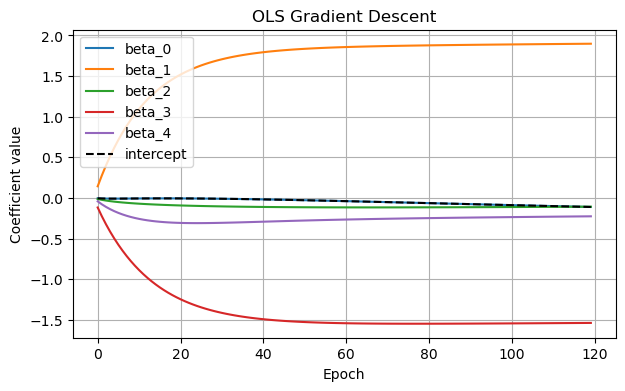

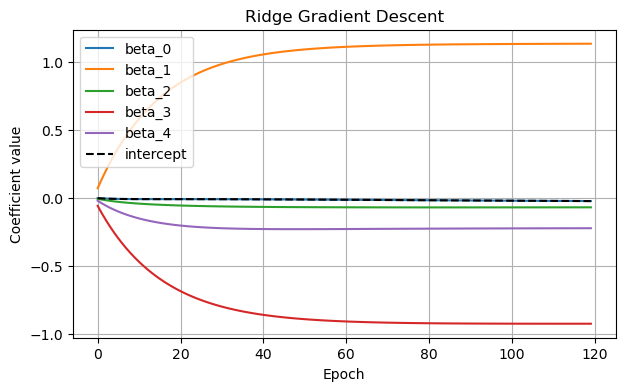

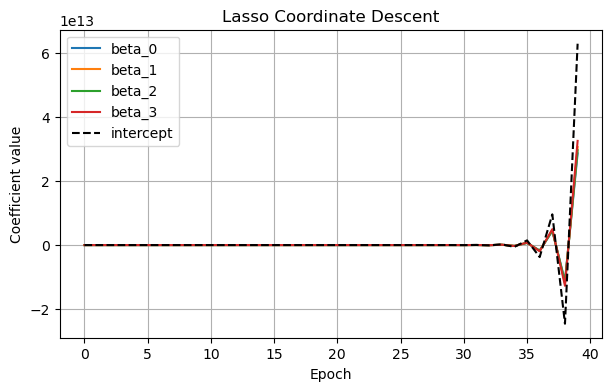

In [ ]:
# beta_0 = intercept
hist_ols = fit_ols_gd_with_history(X, y)
plot_hist(hist_ols, "OLS Gradient Descent")

# beta_0 = intercept
hist_rigi = fit_ridge_gd_with_history(X, y)
plot_hist(hist_rigi, "Ridge Gradient Descent")


hist_lasso = fit_lasso_cd_with_history(X, y)
plot_hist(hist_lasso, "Lasso Coordinate Descent")

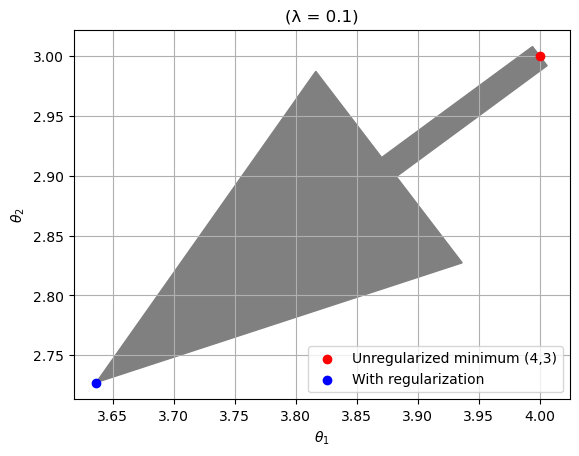

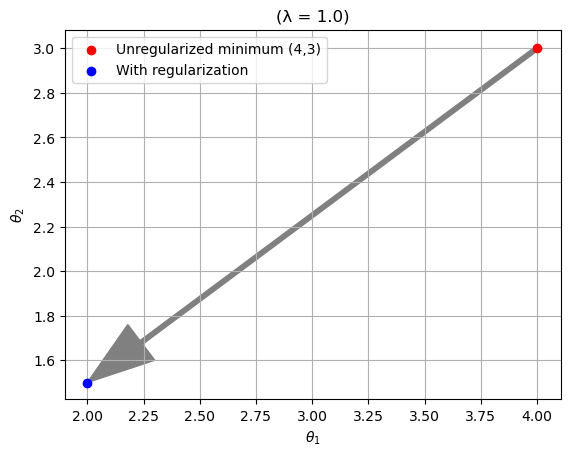

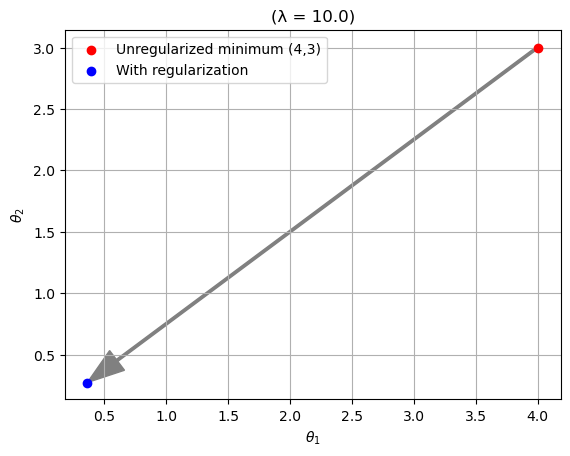

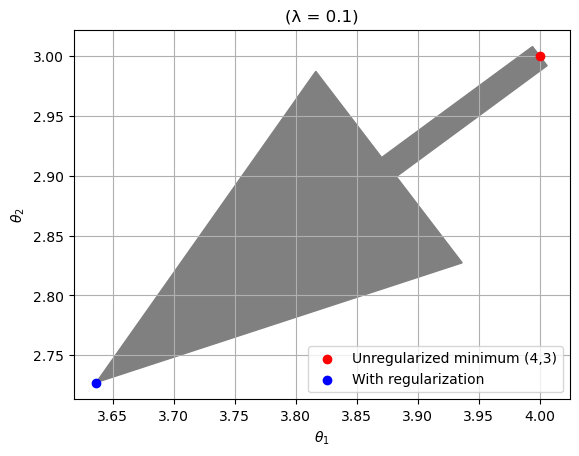

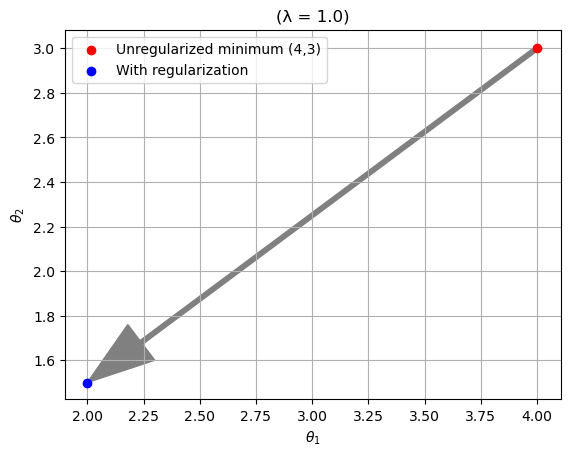

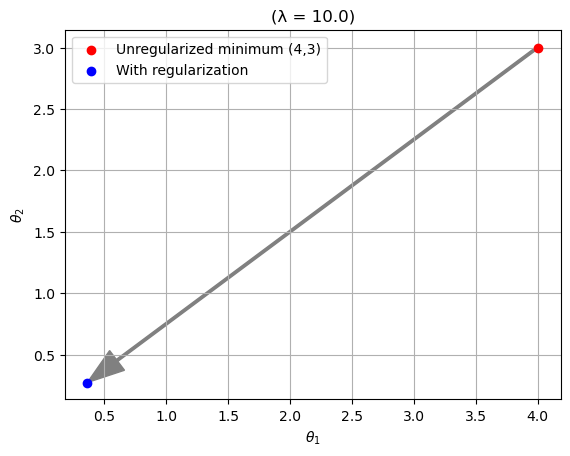

In [ ]:
# This is just for visualizing exercise 3 from sheet 4
def plot_regularization_decay(lambda_reg=0.0, eigenvalue=0.0):
 
    theta1_star = eigenvalue / (eigenvalue+ (lambda_reg*eigenvalue)) * 4
    theta2_star = eigenvalue / (eigenvalue+ (lambda_reg*eigenvalue)) * 3

    plt.scatter(4, 3, color='red', label='Unregularized minimum (4,3)', zorder=5)
    plt.scatter(theta1_star, theta2_star, color='blue', label='With regularization', zorder=5)
    

    plt.arrow(4, 3, theta1_star - 4, theta2_star - 3, 
              color='gray', width=0.02, head_width=0.2, length_includes_head=True)

    plt.title(f"(λ = {lambda_reg})")
    plt.xlabel(r"$\theta_1$")
    plt.ylabel(r"$\theta_2$")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_regularization_decay(lambda_reg=0.1, eigenvalue=0.5)
plot_regularization_decay(lambda_reg=1.0, eigenvalue=0.5)
plot_regularization_decay(lambda_reg=10.0, eigenvalue=0.5)

plot_regularization_decay(lambda_reg=0.1, eigenvalue=10)
plot_regularization_decay(lambda_reg=1.0, eigenvalue=10)
plot_regularization_decay(lambda_reg=10.0, eigenvalue=10)